# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/human_values.png?raw=1" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# system packages
from pathlib import Path
import shutil
import urllib
import tarfile
import sys

# data and numerical management packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report

# useful during debugging (progress bars)
from tqdm import tqdm

# random seed
import random

In [ ]:
!pip install torch==1.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers==4.30.0
!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate
!pip install tensordict

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, EvalPrediction, TrainerCallback, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
torch.cuda.is_available()

True

In [6]:
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    generator = np.random.default_rng(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    return generator

#### Download

In [7]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def clean_download(url, name, folder):
    print(f"Current work directory: {Path.cwd()}")
    dataset_folder = Path.cwd().joinpath("Datasets").joinpath(folder)

    if not dataset_folder.exists():
        dataset_folder.mkdir(parents=True)

    dataset_path = dataset_folder.joinpath(name)

    if not dataset_path.exists():
        download_dataset(dataset_path, url)

In [ ]:
arguments_split = ["arguments-training.tsv", "arguments-validation.tsv", "arguments-test.tsv"]
labels_split = ["labels-training.tsv", "labels-validation.tsv", "labels-test.tsv"]

for argument in arguments_split:
    url = "https://zenodo.org/records/8248658/files/" + argument + "?download=1"
    clean_download(url, argument, "Arguments")

for label in labels_split:
    url = "https://zenodo.org/records/8248658/files/" + label + "?download=1"
    clean_download(url, label, "Labels")


#### Encode

In [9]:
# Read the arguments split files into DataFrames
arguments_train_df = pd.read_table('Datasets/Arguments/arguments-training.tsv', sep='\t')
arguments_val_df = pd.read_table('Datasets/Arguments/arguments-validation.tsv', sep='\t')
arguments_test_df = pd.read_table('Datasets/Arguments/arguments-test.tsv', sep='\t')

# Read the labels split files into DataFrames
labels_train_df = pd.read_table('Datasets/Labels/labels-training.tsv', sep='\t')
labels_val_df = pd.read_table('Datasets/Labels/labels-validation.tsv', sep='\t')
labels_test_df = pd.read_table('Datasets/Labels/labels-test.tsv', sep='\t')


#### Merge arguments and labels

In [10]:
train_merge_df = pd.merge(arguments_train_df, labels_train_df, on='Argument ID')
val_merge_df = pd.merge(arguments_val_df, labels_val_df, on='Argument ID')
test_merge_df = pd.merge(arguments_test_df, labels_test_df, on='Argument ID')


#### Merge level 2 annotations to level 3 categories

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

In [11]:
level_2_categories = train_merge_df.columns[4:]

In [12]:
level_2_to_Openness_to_change = level_2_categories[:4]
level_2_to_Self_enhancement = level_2_categories[3:8]
level_2_to_Conservation = level_2_categories[7:14]
level_2_to_Self_transcendence = level_2_categories[13:]

In [13]:
def merge_categories(df):
    df['Openness to change'] = [int(any(df[level_2_to_Openness_to_change].loc[i])) for i in range(len(df))]
    df['Self-enhancement'] = [int(any(df[level_2_to_Self_enhancement].loc[i])) for i in range(len(df))]
    df['Conservation'] = [int(any(df[level_2_to_Conservation].loc[i])) for i in range(len(df))]
    df['Self-transcendence'] = [int(any(df[level_2_to_Self_transcendence].loc[i])) for i in range(len(df))]
    return df.drop(level_2_categories, axis=1)

In [14]:
final_train_df = merge_categories(train_merge_df)
final_val_df = merge_categories(val_merge_df)
final_test_df = merge_categories(test_merge_df)

In [15]:
final_train_df.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/model_schema.png?raw=1" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/bert_c.png?raw=1" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/bert_cp.png?raw=1" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/bert_cps.png?raw=1" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="https://github.com/LorenzoScaioli/NLP_multi-label-text-classification-with-transformers/blob/main/images/input_merging.png?raw=1" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

#### Text encoding

Transformers typically use [SentencePiece tokenizer](https://github.com/google/sentencepiece) to perform sub-word level tokenization.

In particular, the `transformers` library offers the `AutoTokenizer` class to quickly retrieve our chosen transformer's ad-hoc tokenizer.

The `model_card` variable defines the *path* where to look for our pre-trained model.

You can check [huggingface's hub](https://huggingface.co/models) model hub to pick the model card according to your preference.

In [16]:
labels = ['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']
num_labels = len(labels)
id2label = {i:label for i, label in enumerate(labels)}
label2id = {label:i for i, label in enumerate(labels)}

Encoding Stance in numerical format

In [17]:
le = LabelEncoder()

def encode_stance(df):
    return le.fit_transform(df['Stance'])

final_train_df['Stance'] = encode_stance(final_train_df)
final_val_df['Stance'] = encode_stance(final_val_df)
final_test_df['Stance'] = encode_stance(final_test_df)

In [18]:
final_train_df

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,0,0,1,1
...,...,...,...,...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,1,"On the one hand, we have Russia killing countl...",0,1,1,1
5389,E08017,Food whose production has been subsidized with...,1,The subsidies were originally intended to ensu...,0,0,1,1
5390,E08018,Food whose production has been subsidized with...,1,These products come mainly from large enterpri...,0,0,0,1
5391,E08019,Food whose production has been subsidized with...,1,Subsidies often make farmers in recipient coun...,0,0,1,1


In [19]:
train_dataset = Dataset.from_pandas(final_train_df)
val_dataset = Dataset.from_pandas(final_val_df)
test_dataset = Dataset.from_pandas(final_test_df)

In [20]:
model_card = 'prajjwal1/bert-tiny'

tokenizer = AutoTokenizer.from_pretrained(model_card)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
def preprocess_data_conclusion(dataset):
  text = dataset["Conclusion"]
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)

  labels_batch = {k: dataset[k] for k in dataset.keys() if k in labels}
  labels_matrix = np.zeros((len(text), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding



def preprocess_data_conclusion_premise(dataset):
  text1 = dataset["Conclusion"]
  text2 = dataset["Premise"]
  encoding = tokenizer(text1, text2, padding="max_length", truncation=True, max_length=512)

  labels_batch = {k: dataset[k] for k in dataset.keys() if k in labels}
  labels_matrix = np.zeros((len(text1), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding



def preprocess_data_conclusion_premise_stance(dataset):
  text1 = dataset["Conclusion"]
  text2 = dataset["Premise"]
  text3 = list(map(str, dataset["Stance"]))
  text = []
  for i, t in enumerate(text1):
    text.append(t + '[SEP]' + text3[i])
  encoding = tokenizer(text, text2, padding="max_length", truncation=True, max_length=512)

  labels_batch = {k: dataset[k] for k in dataset.keys() if k in labels}
  labels_matrix = np.zeros((len(text1), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

In [22]:
encoded_c_train_dataset = train_dataset.map(preprocess_data_conclusion, batched=True, remove_columns=train_dataset.column_names)
encoded_c_val_dataset = val_dataset.map(preprocess_data_conclusion, batched=True, remove_columns=val_dataset.column_names)
encoded_c_test_dataset = test_dataset.map(preprocess_data_conclusion, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [23]:
encoded_cp_train_dataset = train_dataset.map(preprocess_data_conclusion_premise, batched=True, remove_columns=train_dataset.column_names)
encoded_cp_val_dataset = val_dataset.map(preprocess_data_conclusion_premise, batched=True, remove_columns=val_dataset.column_names)
encoded_cp_test_dataset = test_dataset.map(preprocess_data_conclusion_premise, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [24]:
encoded_cps_train_dataset = train_dataset.map(preprocess_data_conclusion_premise_stance, batched=True, remove_columns=train_dataset.column_names)
encoded_cps_val_dataset = val_dataset.map(preprocess_data_conclusion_premise_stance, batched=True, remove_columns=val_dataset.column_names)
encoded_cps_test_dataset = test_dataset.map(preprocess_data_conclusion_premise_stance, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [25]:
encoded_dataset_dict = {
    'c_model' : [encoded_c_train_dataset, encoded_c_val_dataset, encoded_c_test_dataset],
    'cp_model' : [encoded_cp_train_dataset, encoded_cp_val_dataset, encoded_cp_test_dataset],
    'cps_model' : [encoded_cps_train_dataset, encoded_cps_val_dataset, encoded_cps_test_dataset]
}

### Others

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch datasets.

In [26]:
encoded_c_train_dataset.set_format("torch")
encoded_c_val_dataset.set_format("torch")
encoded_c_test_dataset.set_format("torch")

encoded_cp_train_dataset.set_format("torch")
encoded_cp_val_dataset.set_format("torch")
encoded_cp_test_dataset.set_format("torch")

encoded_cps_train_dataset.set_format("torch")
encoded_cps_val_dataset.set_format("torch")
encoded_cps_test_dataset.set_format("torch")

### Implementing a random uniform classifier for each category

In [27]:
uniform_classifiers = [DummyClassifier(strategy="uniform"), DummyClassifier(strategy="uniform"), DummyClassifier(strategy="uniform"), DummyClassifier(strategy="uniform")]

### Implementing a majority classifier for each category

In [28]:
majority_classifiers = [DummyClassifier(strategy="most_frequent"), DummyClassifier(strategy="most_frequent"), DummyClassifier(strategy="most_frequent"), DummyClassifier(strategy="most_frequent")]

### Defining a BERT-based classifier that receives an argument **conclusion** as input.

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
def create_models():
    c_model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                             problem_type="multi_label_classification",
                                                             num_labels=num_labels,
                                                             id2label=id2label,
                                                             label2id=label2id)

    cp_model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                                problem_type="multi_label_classification",
                                                                num_labels=num_labels,
                                                                id2label=id2label,
                                                                label2id=label2id)

    cps_model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                                problem_type="multi_label_classification",
                                                                num_labels=num_labels,
                                                                id2label=id2label,
                                                                label2id=label2id)
    return [c_model, cp_model, cps_model]

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conservation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conservation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [31]:
threshold = 0.5
cr_dict = None

def compute_metrics(p: EvalPrediction):
    global cr_dict
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    true_labels=p.label_ids

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = true_labels

    accuracy = []

    if cr_dict is None:
        cr_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
        for key,value in cr_dict.items():
            cr_dict[key] = {k: [v] for k,v in value.items()}
            cr_dict[key]['accuracy'] = []
            if key in labels:
                accuracy.append(accuracy_score(y_true[:, label2id[key]], y_pred[:, label2id[key]]))
                cr_dict[key]['accuracy'].append(accuracy[-1])
        cr_dict['macro avg']['accuracy'].append(np.mean(accuracy))
    else:
        cr = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
        for key,value in cr.items():
            for k in value.keys():
                cr_dict[key][k].append(cr[key][k])
            if key in labels:
                accuracy.append(accuracy_score(y_true[:, label2id[key]], y_pred[:, label2id[key]]))
                cr_dict[key]['accuracy'].append(accuracy[-1])
        cr_dict['macro avg']['accuracy'].append(np.mean(accuracy))

    macro_precision = cr_dict['macro avg']['precision'][-1]
    macro_recall = cr_dict['macro avg']['recall'][-1]
    macro_f1 = cr_dict['macro avg']['f1-score'][-1]
    macro_accuracy = cr_dict['macro avg']['accuracy'][-1]

    # return the metrics as a dictionary
    return {'f1': macro_f1, 'precision': macro_precision, 'recall': macro_recall, 'accuracy': macro_accuracy}

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

#### Baseline training

In [32]:
X_train = final_train_df['Conclusion'] + ' ' + final_train_df['Stance'].astype(str) + ' ' + final_train_df['Premise']
X_val = final_val_df['Conclusion'] + ' ' + final_val_df['Stance'].astype(str) + ' ' + final_val_df['Premise']

def train_baseline(strategy):
    cr, cm = [], []
    for i, label in enumerate(labels):
        y_train = final_train_df[labels[i]]
        if strategy == 'uniform':
            uniform_classifiers[i].fit(X_train, y_train)
        elif strategy == 'majority':
            majority_classifiers[i].fit(X_train, y_train)

        y_true = final_val_df[labels[i]]
        y_pred = None
        if strategy == 'uniform':
            y_pred = uniform_classifiers[i].predict(X_val)
        elif strategy == 'majority':
            y_pred = majority_classifiers[i].predict(X_val)

        cr.append(classification_report(y_true, y_pred, output_dict=True, zero_division=0))
        cm.append(confusion_matrix(y_true, y_pred, normalize='true'))
    return cm, cr

uniform_cm, uniform_cr = train_baseline('uniform')
majority_cm, majority_cr = train_baseline('majority')

In [33]:
def plot_baseline(cm):
    plt.figure(figsize=(10,10))
    for i, category_cm in enumerate(cm):
        plt.subplot(2, 2, i+1)
        sns.heatmap(category_cm, annot=True, fmt='.1%', cmap='Blues')
        plt.title('Confusion Matrix - ' + labels[i])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.show()

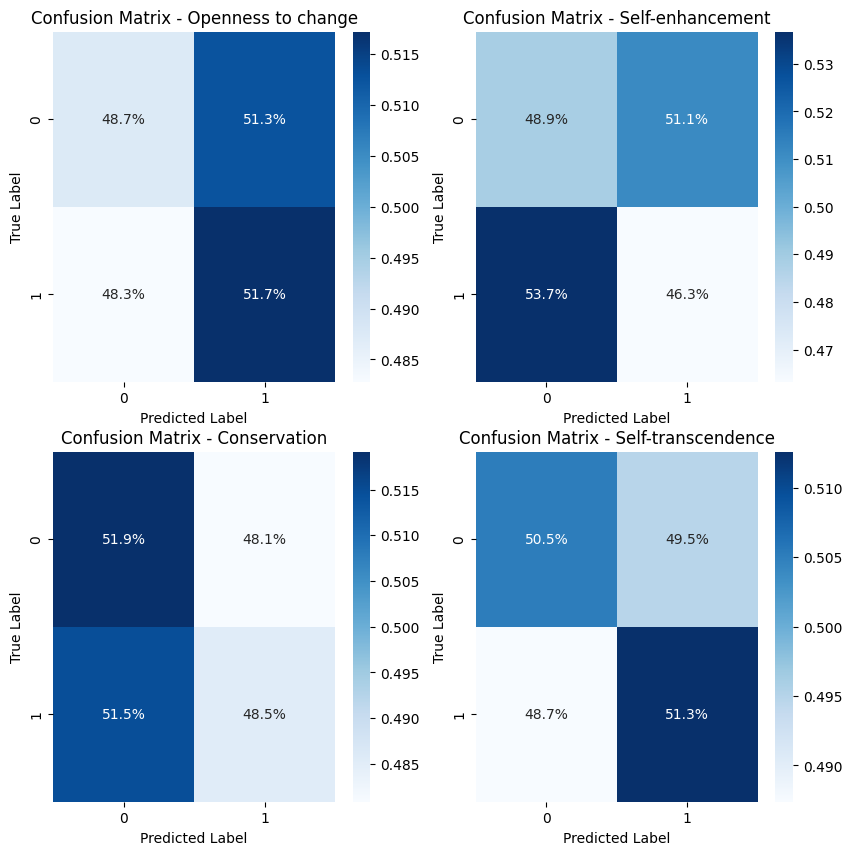

In [34]:
plot_baseline(uniform_cm)

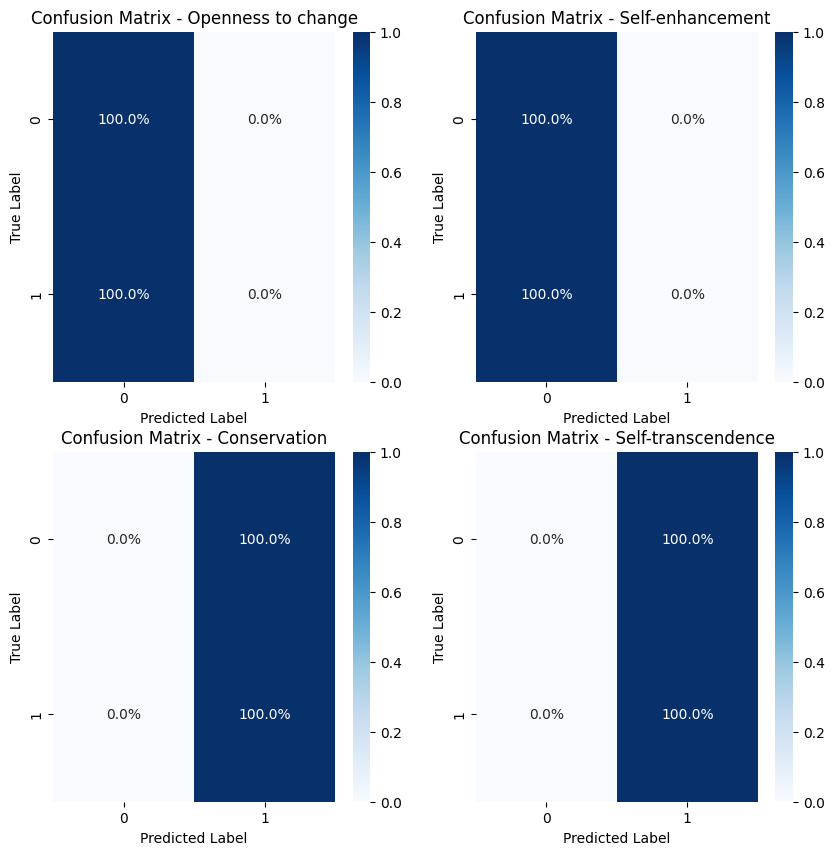

In [35]:
plot_baseline(majority_cm)

#### BERT Training

In [36]:
batch_size = 8

In [37]:
args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=0.001,
    per_device_train_batch_size=batch_size,         # accelerate defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

In [38]:
def create_trainers(models):
    c_optimizer = torch.optim.ASGD(models[0].parameters(), lr = 0.001)
    c_reduce_lr = ReduceLROnPlateau(c_optimizer, 'min', factor=0.5, patience=10, verbose=True)

    c_trainer = Trainer(
        model=models[0],
        args=args,
        train_dataset=encoded_c_train_dataset,
        eval_dataset=encoded_c_val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        optimizers=[c_optimizer, c_reduce_lr]
    )

    cp_optimizer = torch.optim.ASGD(models[1].parameters(), lr = 0.001)
    cp_reduce_lr = ReduceLROnPlateau(cp_optimizer, 'min', factor=0.5, patience=10, verbose=True)

    cp_trainer = Trainer(
        model=models[1],
        args=args,
        train_dataset=encoded_cp_train_dataset,
        eval_dataset=encoded_cp_val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        optimizers=[cp_optimizer, cp_reduce_lr]
    )

    cps_optimizer = torch.optim.ASGD(models[2].parameters(), lr = 0.001)
    cps_reduce_lr = ReduceLROnPlateau(cps_optimizer, 'min', factor=0.5, patience=10, verbose=True)

    cps_trainer = Trainer(
        model=models[2],
        args=args,
        train_dataset=encoded_cps_train_dataset,
        eval_dataset=encoded_cps_val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        optimizers=[cps_optimizer, cps_reduce_lr]
    )

    return [c_trainer, cp_trainer, cps_trainer]

In [39]:
def download_model(model_name, model_seed):
    model_folder = Path.cwd().joinpath(f"models/{model_name}")

    for name in [f"my_history_{model_name}_{model_seed}.npy", f"my_metrics_val_{model_name}_{model_seed}.npy", f"my_metrics_test_{model_name}_{model_seed}.npy", f"my_val_predictions_{model_name}_{model_seed}.npy", f"my_test_predictions_{model_name}_{model_seed}.npy"]: #, f"my_cm_val_{model_name}_{model_seed}.npy", f"my_cm_test_{model_name}_{model_seed}.npy"]:
        url = f"https://github.com/LorenzoScaioli/NLP-Models/raw/main/models_Assigment_2/{model_name}/{name}"

        checkpoint_history = model_folder.joinpath(f"{name}")

        if not checkpoint_history.exists():
            download_dataset(checkpoint_history, url)

    url = f"https://github.com/LorenzoScaioli/NLP-Models/raw/main/models_Assigment_2/{model_name}/{model_name}_{model_seed}.pth"
    model_path = model_folder.joinpath(f"{model_name}_{model_seed}.pth")

    if not model_path.exists():
        download_dataset(model_path, url)

In [40]:
from urllib.error import HTTPError

def get_model(trainer, model, name, model_seed, train_model):
    global cr_dict
    models_folder = Path.cwd().joinpath("models")

    if not models_folder.exists():
        models_folder.mkdir(parents=True)

    model_folder = models_folder.joinpath(f"{name}")

    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    model_path = model_folder.joinpath(f"{name}_{model_seed}.pth")
    checkpoint_dir = model_folder
    checkpoint_path = model_folder.joinpath("/cp.ckpt")

    if train_model:
        trainer.train()
        torch.save(model, model_path)

        history = trainer.state.log_history
        np.save(checkpoint_dir.joinpath(f'my_history_{name}_{model_seed}.npy'), history)
        metrics_dict_val = cr_dict
        np.save(checkpoint_dir.joinpath(f'my_metrics_val_{name}_{model_seed}.npy'), metrics_dict_val)
        cr_dict = None

        val_predict = trainer.predict(test_dataset=encoded_dataset_dict[name][1]).predictions
        np.save(checkpoint_dir.joinpath(f'my_val_predictions_{name}_{model_seed}.npy'), val_predict)
        cr_dict = None

        test_predict = trainer.predict(test_dataset=encoded_dataset_dict[name][2]).predictions
        np.save(checkpoint_dir.joinpath(f'my_test_predictions_{name}_{model_seed}.npy'), test_predict)
        metrics_dict_test = cr_dict
        np.save(checkpoint_dir.joinpath(f'my_metrics_test_{name}_{model_seed}.npy'), metrics_dict_test)
        cr_dict = None
    else:
        try:
            download_model(name, model_seed)
            model = torch.load(model_path)

            history = np.load(checkpoint_dir.joinpath(f'my_history_{name}_{model_seed}.npy'), allow_pickle='TRUE').tolist()
            metrics_dict_val = np.load(checkpoint_dir.joinpath(f'my_metrics_val_{name}_{model_seed}.npy'), allow_pickle='TRUE').tolist()
            metrics_dict_test = np.load(checkpoint_dir.joinpath(f'my_metrics_test_{name}_{model_seed}.npy'), allow_pickle='TRUE').tolist()
            val_predict = np.load(checkpoint_dir.joinpath(f'my_val_predictions_{name}_{model_seed}.npy'), allow_pickle='TRUE').tolist()
            test_predict = np.load(checkpoint_dir.joinpath(f'my_test_predictions_{name}_{model_seed}.npy'), allow_pickle='TRUE').tolist()
        except(HTTPError):
            print()
            print("Error: Model not found! Train it first!")
            return None, None, None, None, None, None

    return model, history, metrics_dict_val, metrics_dict_test, val_predict, test_predict

In [41]:
model_names = ['c_model', 'cp_model', 'cps_model']
seeds = [2115992153, 3236146088, 749713082]
trained_models = []; trained_history = []; trained_metrics_dict_val = [];
trained_metrics_dict_test = []; val_predictions = []; test_predictions = [];
train_model = False

for seed in seeds:
    fix_random(seed=seed)
    models = create_models()
    trainers = create_trainers(models)
    for i in range(3):
        model = models[i]
        trainer = trainers[i]
        name = model_names[i]
        print(f"Model: {name} - Seed: {seed}")
        globals()[f"{name}_{seed}"], globals()[f"history_{name}_{seed}"], globals()[f"metrics_dict_val_{name}_{seed}"], globals()[f"metrics_dict_test_{name}_{seed}"], globals()[f"my_val_predictions_{name}_{seed}"], globals()[f"my_test_predictions_{name}_{seed}"] = get_model(trainer, model, name, seed, train_model)
        print()
        trained_models.append(globals()[f"{name}_{seed}"])
        trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))

        trained_metrics_dict_val.append(globals()[f"metrics_dict_val_{name}_{seed}"])
        trained_metrics_dict_test.append(globals()[f"metrics_dict_test_{name}_{seed}"])

        val_predictions.append(globals()[f"my_val_predictions_{name}_{seed}"])
        test_predictions.append(globals()[f"my_test_predictions_{name}_{seed}"])
    print(" ")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Model: c_model - Seed: 2115992153

Model: cp_model - Seed: 2115992153

Model: cps_model - Seed: 2115992153

 


<ipython-input-41-f77592d1aa3b>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))
<ipython-input-41-f77592d1aa3b>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))
<ipython-input-41-f77592d1aa3b>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNo

Model: c_model - Seed: 3236146088

Model: cp_model - Seed: 3236146088

Model: cps_model - Seed: 3236146088

 


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Model: c_model - Seed: 749713082

Model: cp_model - Seed: 749713082

Model: cps_model - Seed: 749713082

 


<ipython-input-41-f77592d1aa3b>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))
<ipython-input-41-f77592d1aa3b>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  trained_history.append(pd.DataFrame(globals()[f"history_{name}_{seed}"]).groupby('epoch').max().dropna(1))


##Evaluation

In [42]:
def graph_plots(history, model_name):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['eval_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['eval_accuracy'])
    plt.title('Eval Accuracy - ' + model_name)

    plt.subplot(1, 2, 2)
    plt.plot(history['eval_loss'])
    plt.plot(history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['eval_loss', 'loss'])
    plt.title('Loss - ' + model_name)

    plt.tight_layout()
    plt.show()

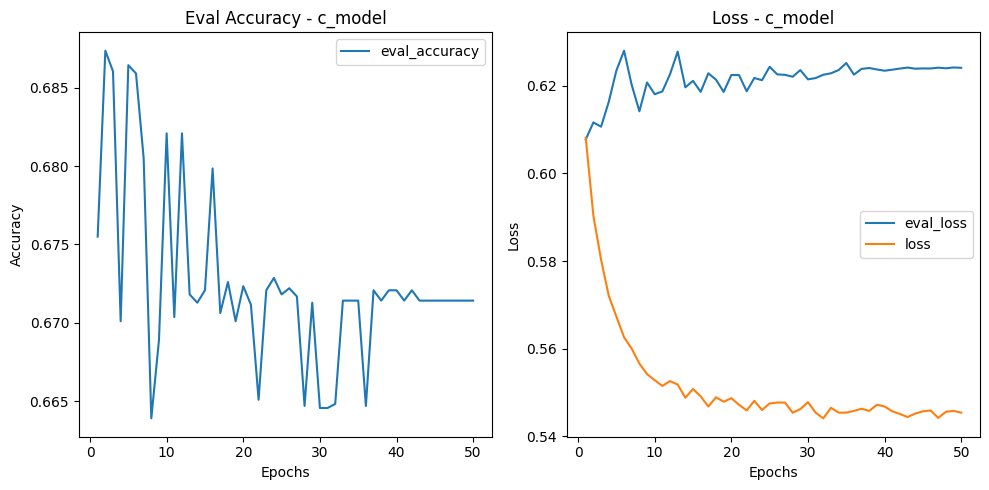

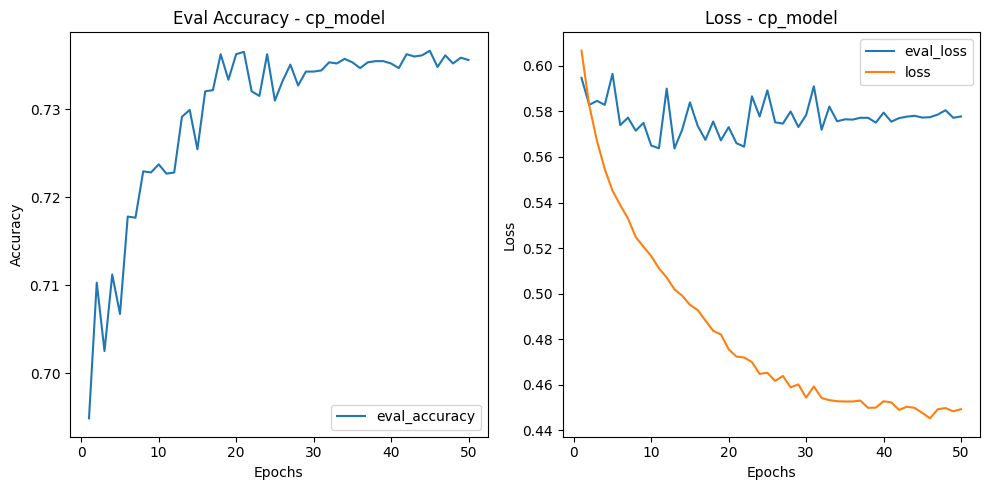

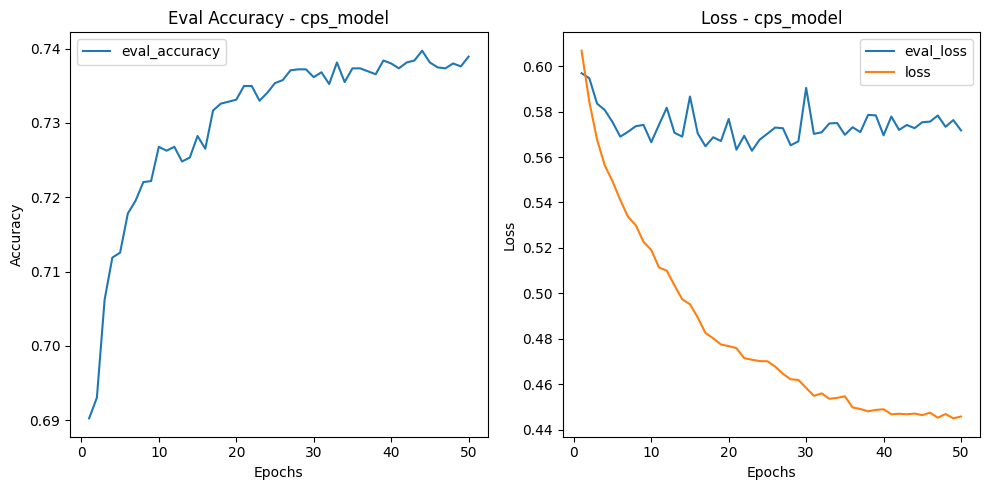

In [43]:
for i, model in enumerate(trained_models[0:3]):
    metrics_dict = trained_history[trained_models.index(model)]
    #cm = trained_cm_test[trained_models.index(model)]
    history = trained_history[trained_models.index(model)]
    graph_plots(history, model_names[i])

###Check robustness of the code

From the graphs below we can see that all the three models are robust because, by changing the seed, the trend of the curve does not change

In [44]:
def check_robustness_model(list_models, list_metrics_dict, metric='f1-score'):
    plt.figure(figsize=(15, 5))
    for i in [0, 1, 2]:
        plt.subplot(1, 3, i+1)
        model_name = model_names[i]
        plt.title(f"{model_name} - {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric}")
        for seed in seeds:
            model = list_models[i:i+7:3][seeds.index(seed)]
            metrics_dict = list_metrics_dict[list_models.index(model)]['macro avg'][metric]
            plt.plot(metrics_dict, label= f"{seed}")
        plt.legend()

    plt.tight_layout()
    plt.show()

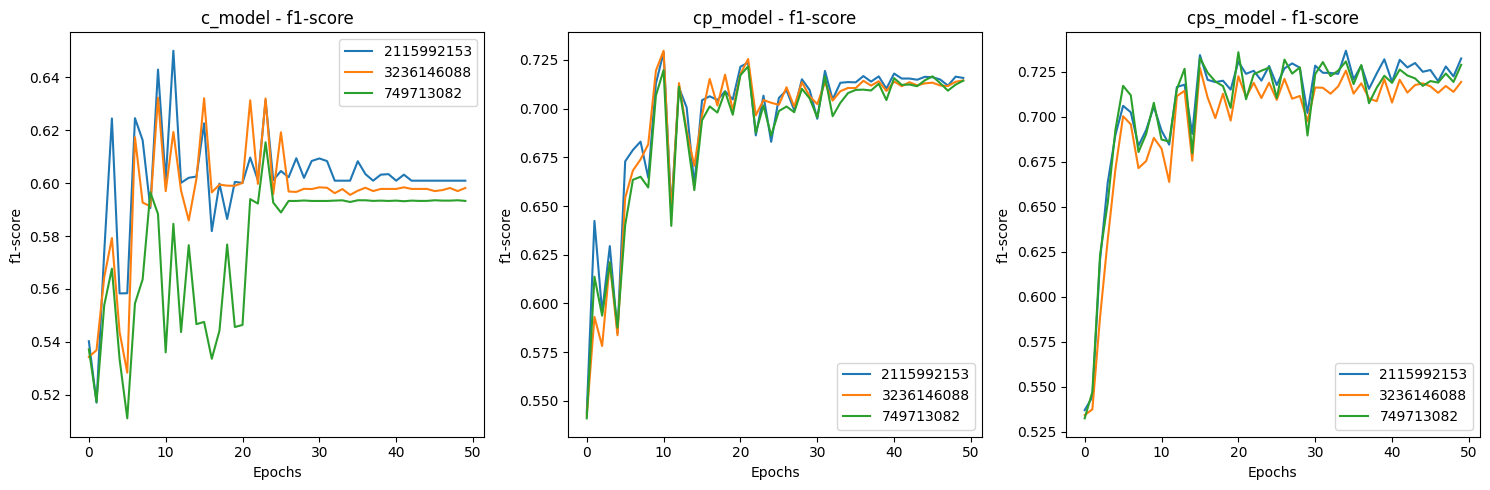

In [45]:
check_robustness_model(trained_models, trained_metrics_dict_val)

###Define best model

In [46]:
seed_nr = 0
best_model = globals()['cps_model_'+str(seeds[seed_nr])]
print(f"Best model: cps_model with seed {seeds[seed_nr]}")

Best model: cps_model with seed 2115992153


###Compute metrics on the validation set

In [47]:
def check_best_model(list_models, list_metrics_dict, seed):
    idx_seed = seeds.index(seed)
    keys = list(list_metrics_dict[0]['macro avg'].keys())
    keys.pop(3)
    models_to_check = [trained_models[i+seed_nr*len(seeds)] for i in range(len(model_names))]

    plt.figure(figsize=(8, 8))
    for metric in keys:
        i = keys.index(metric)
        plt.subplot(2, 2, i+1)

        plt.title(f"Metric: {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric}")
        for model in models_to_check:
            metrics_dict = list_metrics_dict[list_models.index(model)]['macro avg'][metric]
            plt.plot(metrics_dict, label= f"{model_names[models_to_check.index(model)]}")
        plt.legend()

    plt.tight_layout()
    plt.show()

In [48]:
for i, name in enumerate(model_names):
    model = trained_models[i+seed_nr*len(seeds)]
    model_metrics = dict()
    for key in trained_metrics_dict_val[0]['macro avg'].keys():
        model_metrics[key] = trained_metrics_dict_val[i+seed_nr*len(seeds)]['macro avg'][key][-1]
    print("Macro avg of the metrics of " + name+": Val f1: {:.4f} - Val precision: {:.4f} - Val recall: {:.4f} - Val accuracy: {:.4f}"
    .format(model_metrics['f1-score'], model_metrics['precision'], model_metrics['recall'], model_metrics['accuracy']))

Macro avg of the metrics of c_model: Val f1: 0.6009 - Val precision: 0.6094 - Val recall: 0.6316 - Val accuracy: 0.6714
Macro avg of the metrics of cp_model: Val f1: 0.7158 - Val precision: 0.7357 - Val recall: 0.7245 - Val accuracy: 0.7356
Macro avg of the metrics of cps_model: Val f1: 0.7324 - Val precision: 0.7296 - Val recall: 0.7555 - Val accuracy: 0.7389


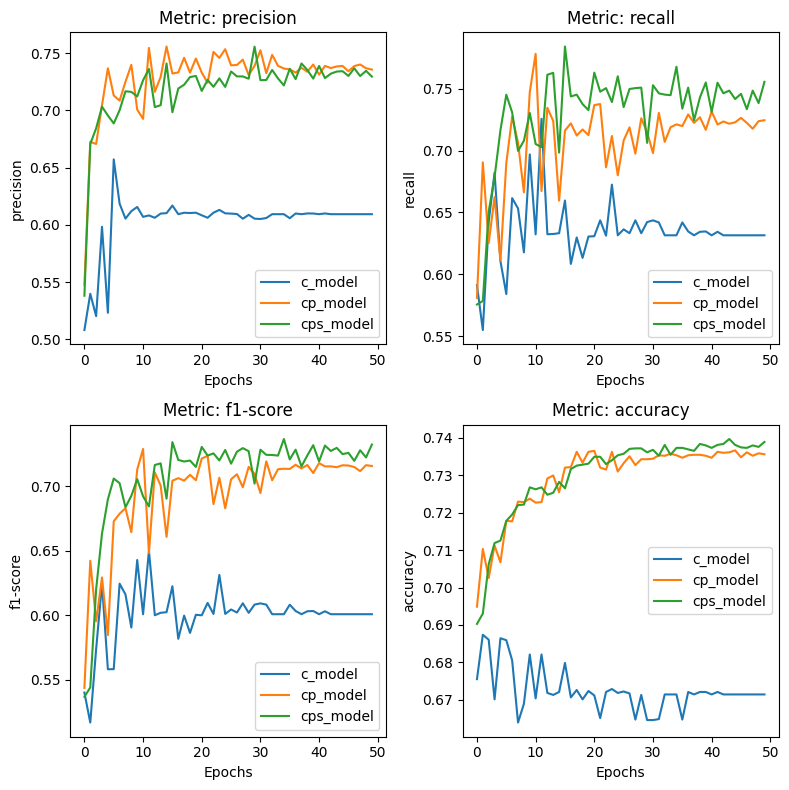

In [49]:
check_best_model(trained_models, trained_metrics_dict_val, seed=seeds[seed_nr])

###Report per-category and macro F1-score for comparison.

In [50]:
for i, name in enumerate(model_names):
    model = trained_models[i+seed_nr*len(seeds)]
    model_categories = dict()
    for key in list(trained_metrics_dict_val[0].keys())[:4]:
        model_categories[key] = trained_metrics_dict_val[i+seed_nr*len(seeds)][key]['f1-score'][-1]
    print("f1-score of " + name+" by category: Openness to change: {:.4f} - Self-enhancement: {:.4f} - Conservation: {:.4f} - Self-transcendence: {:.4f}"
    .format(model_categories['Openness to change'], model_categories['Self-enhancement'], model_categories['Conservation'], model_categories['Self-transcendence']))
    print("f1-score macro avg of " + name + ": {:.4f}".format(trained_metrics_dict_val[i+seed_nr*len(seeds)]['macro avg']['f1-score'][-1]))

f1-score of c_model by category: Openness to change: 0.2188 - Self-enhancement: 0.4411 - Conservation: 0.8585 - Self-transcendence: 0.8854
f1-score macro avg of c_model: 0.6009
f1-score of cp_model by category: Openness to change: 0.4978 - Self-enhancement: 0.6243 - Conservation: 0.8586 - Self-transcendence: 0.8825
f1-score macro avg of cp_model: 0.7158
f1-score of cps_model by category: Openness to change: 0.5596 - Self-enhancement: 0.6236 - Conservation: 0.8652 - Self-transcendence: 0.8810
f1-score macro avg of cps_model: 0.7324


In [51]:
def plot_per_category(list_models, list_metrics_dict, seed):
    idx_seed = seeds.index(seed)
    keys = list(list_metrics_dict[0].keys())[:4]
    models_to_check = [trained_models[i+seed_nr*len(seeds)] for i in range(len(model_names))]

    plt.figure(figsize=(8, 8))
    for category in keys:
        i = keys.index(category)
        plt.subplot(2, 2, i+1)

        plt.title(f"Category {category} f1-score")
        plt.xlabel("Epochs")
        plt.ylabel('f1-score')
        for model in models_to_check:
            metrics_dict = list_metrics_dict[list_models.index(model)][category]['f1-score']
            plt.plot(metrics_dict, label= f"{model_names[models_to_check.index(model)]}")
        plt.legend()

    plt.tight_layout()
    plt.show()

In [52]:
def plot_macro_avg_f1(list_models, list_metrics_dict, seed):
    idx_seed = seeds.index(seed)
    models_to_check = [trained_models[i+seed_nr*len(seeds)] for i in range(len(model_names))]

    plt.title("macro avg f1-score")
    plt.xlabel("Epochs")
    plt.ylabel('f1-score')
    for model in models_to_check:
        metrics_dict = list_metrics_dict[list_models.index(model)]['macro avg']['f1-score']
        plt.plot(metrics_dict, label= f"{model_names[models_to_check.index(model)]}")
    plt.legend()

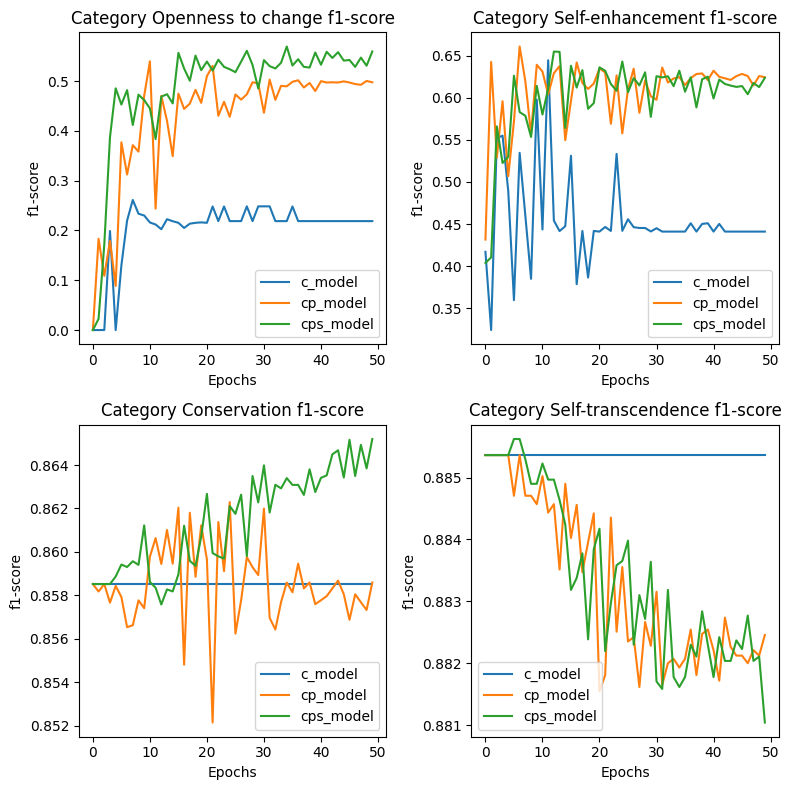

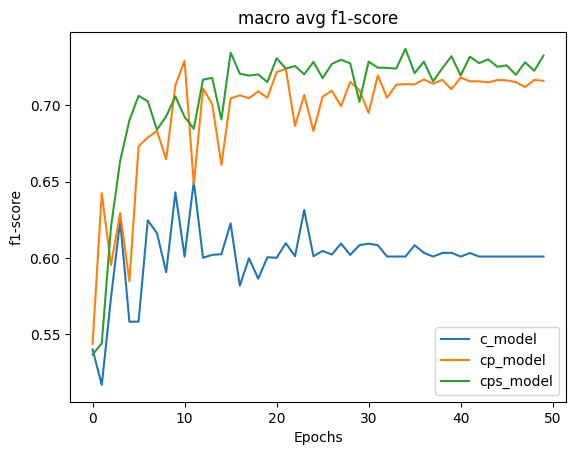

In [53]:
plot_per_category(trained_models, trained_metrics_dict_val, seed=seeds[seed_nr])
plot_macro_avg_f1(trained_models, trained_metrics_dict_val, seed=seeds[seed_nr])

# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

In [54]:
def prepare_data_to_plot(metrics_dict, metric):
    data_to_plot = {}
    avg_c_model, avg_cp_model, avg_cps_model = 0, 0, 0
    for i in range(len(labels)):
        data_to_plot[labels[i]] = {'c_model':metrics_dict[0][labels[i]][metric][-1],
                                   'cp_model':metrics_dict[1][labels[i]][metric][-1],
                                   'cps_model':metrics_dict[2][labels[i]][metric][-1]}
        avg_c_model += metrics_dict[0][labels[i]][metric][-1]
        avg_cp_model += metrics_dict[1][labels[i]][metric][-1]
        avg_cps_model += metrics_dict[2][labels[i]][metric][-1]
    data_to_plot['Average'] = {'c_model':avg_c_model/4,
                                     'cp_model':avg_cp_model/4,
                                     'cps_model':avg_cps_model/4}
    return pd.DataFrame(data_to_plot).reset_index(names=['model']).melt(id_vars=['model'], var_name='category', value_name='f1-score')


def prepare_data_to_plot_baselines(uniform, majority, metrics_dict, metric):
    data_to_plot = {}
    avg_uniform, avg_majority, avg_cps_model = 0, 0, 0
    for i in range(len(labels)):
        data_to_plot[labels[i]] = {'uniform':uniform[i]['1'][metric],
                                   'majority':majority[i]['1'][metric],
                                   'cps_model':metrics_dict[2][labels[i]][metric][-1]}
        avg_uniform += uniform[i]['1'][metric]
        avg_majority += majority[i]['1'][metric]
        avg_cps_model += metrics_dict[2]['macro avg'][metric][-1]
    data_to_plot['Average'] = {'uniform':avg_uniform/4,
                                     'majority':avg_majority/4,
                                     'cps_model':avg_cps_model/4}
    return pd.DataFrame(data_to_plot).reset_index(names=['model']).melt(id_vars=['model'], var_name='category', value_name='f1-score')


def plot_comparison(data, metric):
    plt.figure(figsize=(10,7))
    sns.set_style(style="darkgrid")

    sns.barplot(data=data, x='category', y='f1-score', hue='model')
    sns.lineplot(data=data, x='category', y='f1-score', hue='model', style='model', markers=True)

    plt.xlabel('Categories')
    plt.ylabel(metric)
    plt.title(f'Compare {metric} between different models and categories')

In [55]:
f1_baselines = prepare_data_to_plot_baselines(uniform_cr, majority_cr, trained_metrics_dict_val, 'f1-score')

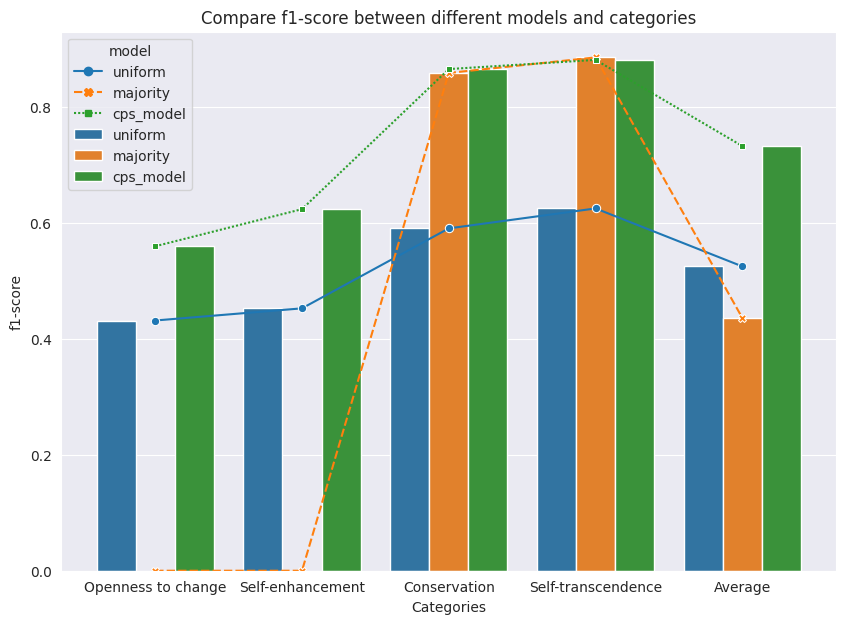

In [56]:
plot_comparison(f1_baselines, 'f1-score')

In [57]:
f1 = prepare_data_to_plot(trained_metrics_dict_val, 'f1-score')

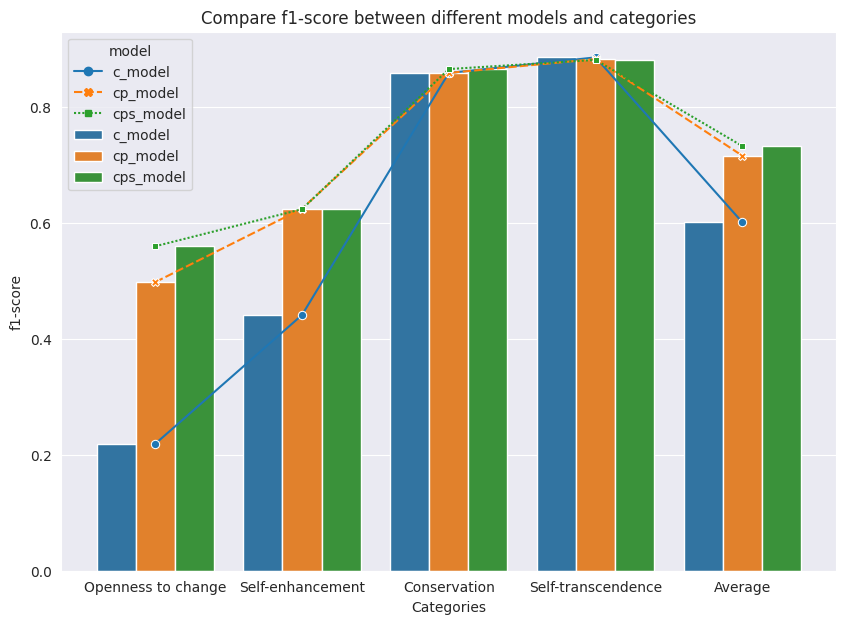

In [58]:
plot_comparison(f1, 'f1-score')

###Predictions

In [59]:
y_test_true_cps = encoded_cps_test_dataset['labels'].numpy()
y_test_true_cp = encoded_cp_test_dataset['labels'].numpy()
y_test_true_c = encoded_c_test_dataset['labels'].numpy()

probabilities_cps = test_predictions[2]
probabilities_cp = test_predictions[1]
probabilities_c = test_predictions[0]

y_test_pred_cps = np.zeros((len(probabilities_cps), len(probabilities_cps[0])))
y_test_pred_cp = np.zeros((len(probabilities_cp), len(probabilities_cp[0])))
y_test_pred_c = np.zeros((len(probabilities_c), len(probabilities_c[0])))

y_test_pred_cps[np.where(np.array(probabilities_cps)>=0)] = 1
y_test_pred_cp[np.where(np.array(probabilities_cp)>=0)] = 1
y_test_pred_c[np.where(np.array(probabilities_c)>=0)] = 1

In [60]:
n_phrase = np.random.randint(0, len(final_test_df))
print(n_phrase)

print('Conclusion:       ' + final_test_df['Conclusion'][n_phrase])
print('Stance:           ' + str(final_test_df['Stance'][n_phrase]))
print('Premise:          ' + final_test_df['Premise'][n_phrase])
print('True labels:      ' + str(y_test_true_cps[n_phrase]))
print('Pred labels CPS : ' + str(y_test_pred_cps[n_phrase]))
print('Pred labels CP  : ' + str(y_test_pred_cp[n_phrase]))
print('Pred labels C   : ' + str(y_test_pred_c[n_phrase]))

1126
Conclusion:       We should ban naturopathy
Stance:           0
Premise:          Naturopaths seek to prevent illness by identifying and treating health problems before they turn into illnesses.
True labels:      [0. 1. 1. 1.]
Pred labels CPS : [0. 0. 1. 1.]
Pred labels CP  : [0. 0. 1. 1.]
Pred labels C   : [0. 0. 1. 1.]


### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End